# Multi-resolution deconvolution of spatial transcriptomics

In this tutorial, we through the steps of applying DestVI for deconvolution of 10x Visium spatial transcriptomics profiles using an accompanying single-cell RNA sequencing data.

**Background:**

Spatial transcriptomics technologies are currently limited, because their resolution is limited to niches (spots) of sizes well beyond that of a single cell. Although several pipelines proposed joint analysis with single-cell RNA-sequencing (scRNA-seq) to alleviate this problem they are limited to a discrete view of cell type proportion inside every spot. This limitation becomes critical in the common case where, even within a cell type, there is a continuum of cell states. We present *Deconvolution of Spatial Transcriptomics profiles using Variational Inference (DestVI)*, a probabilistic method for multi-resolution analysis for spatial transcriptomics that explicitly models continuous variation within cell types.

**Plan for this tutorial:**

1. Loading the data
1. Training the single-cell model (scLVM) to learn a basis of gene expression on the scRNA-seq data
1. Training the spatial model (stLVM) to perform the deconvolution
1. Visualize the learned cell type proportions
1. Run our automated pipeline
1. Dig into the intra cell type information
1. Run cell-type specific differential expression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/yoseflab/destvi_utils.git@main

In [2]:
import destvi_utils
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from scvi.model import CondSCVI, DestVI

import pandas as pd
import os
from scipy.io import mmread

Global seed set to 0
/home/yinuo/.local/lib/python3.8/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/home/yinuo/.local/lib/python3.8/site-packages/flax/struct.py:144: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/yinuo/.local/lib/python3.8/site-packages/flax/struct.py:144: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [5]:
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'
spatial_path = '../data/simu_5/' 
results_path = '../simulation/results/'

### (1). Major cell-type simulation (`simu_5`)

#### Data loading & processing

First, let's load the single-cell data. We profiled immune cells from murine lymph nodes with 10x Chromium, as a control / case study to study the immune response to exposure to a mycobacteria (refer to our paper for more info). We provide the preprocessed data from our reproducibility repository: it contains the raw counts (DestVI always takes raw counts as input).

In [ ]:
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'
spatial_path = '../data/simu_5/' 
results_path = '../simulation/results/'

In [16]:
# Load cell & gene labels
barcode_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_barcodes.tsv'), 
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE barcode
)

gene_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_genes.tsv'),
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE gene
)

# Construct adata object for scRNA-seq
barcodes = pd.DataFrame(barcode_df[0].values, index=barcode_df[0].values, columns=['Barcode'])
genes = pd.DataFrame(gene_df[0].values, index=gene_df[0].values, columns=['features'])

cnt = mmread(
    os.path.join(sc_path, 'count_matrix_sparse.mtx')
).toarray()

sc_adata = sc.AnnData(
    X=cnt.T,
    obs=barcodes,
    var=genes
)
print(sc_adata.shape)

/tmp/ipykernel_3573301/2795640389.py:22: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sc_adata = sc.AnnData(


(7986, 29733)


In [10]:
# Load ground-truth proportion & densities
mem_df = pd.read_csv(os.path.join(spatial_path, 'members.st_synth.csv'),index_col=0)
prop_df = pd.read_csv(os.path.join(spatial_path, 'proportions.st_synth.csv'),index_col=0)

In [17]:
# Rename annotations & only keep scRNA-seq index with cell types existing in the synthetic ST data
major_dict = {
    'CAFs': 'CAFs',
    'Cancer Epithelial': 'Cancer_Epithelial',
    'Myeloid': 'Myeloid',
    'Normal Epithelial': 'Normal_Epithelial',
    'T-cells': 'T-cells'
}

meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)
annots = meta_df['celltype_major'].apply(lambda x: major_dict[x] if x in major_dict.keys() else np.nan)

cells_to_keep = annots.isin(prop_df.columns)
sc_adata = sc_adata[cells_to_keep, :]
annots = annots[cells_to_keep]
sc_adata.obs['major_cell_types'] = annots[cells_to_keep].tolist()

sc_adata

/tmp/ipykernel_3573301/2575017067.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata.obs['major_cell_types'] = annots[cells_to_keep].tolist()


AnnData object with n_obs × n_vars = 7261 × 29733
    obs: 'Barcode', 'major_cell_types'
    var: 'features'

Load simulated spatial data:

In [19]:
st_adata = sc.AnnData(pd.read_csv(os.path.join(spatial_path, 'counts.st_synth.csv'), index_col=0))

# Add spatial locations
xx, yy = np.meshgrid(np.arange(50), np.arange(50), indexing='ij')
xx, yy = xx.flatten(), yy.flatten()
st_adata.obsm["location"] = np.column_stack((yy, xx))

st_adata

AnnData object with n_obs × n_vars = 2500 × 29631
    obsm: 'location'

We clustered the single-cell data by major immune cell types. DestVI can resolve beyond discrete clusters, but need to work with an existing level of clustering. A rule of thumb to keep in mind while clsutering is that DestVI assumes only a single state from each cell type exists in each spot. For example, resting and inflammed monocytes cannot co-exist in one unique spot according to our assumption. Users may cluster their data so that this modeling assumption is as accurate as possible.

In [20]:
# visualization of sc data
sc_vis = sc_adata.copy()
sc.pp.normalize_total(sc_vis, target_sum=1e4)
sc.pp.log1p(sc_vis)

         Falling back to preprocessing with `sc.pp.pca` and default params.


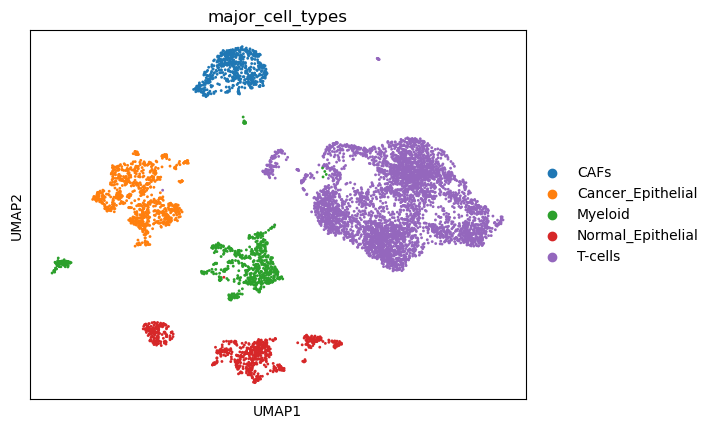

In [21]:
sc.pp.neighbors(sc_vis, n_neighbors=10, n_pcs=40)
sc.tl.umap(sc_vis)
sc.pl.umap(sc_vis, color="major_cell_types")

In [22]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


Now, let's load the spatial data and choose a common gene subset. Users will note that having a common gene set is a prerequisite of the method.

In [23]:
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.obsm["spatial"] = st_adata.obsm["location"]

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [24]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

#### Fit the scLVM

In order to learn cell state specific gene expression patterns, we will fit the single-cell Latent Variable Model (scLVM) to single-cell RNA sequencing data from the same tissue.

In [27]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="major_cell_types")

As a first step, we embed our data using a cell type conditional VAE. We pass the layer containing the raw counts and the labels key. We train this model without reweighting the loss by the cell type abundance. Training will take around 5 minutes in a Colab GPU session.

In [28]:
sc_model = CondSCVI(sc_adata, weight_obs=False)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'major_cell_types', 'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 7261  │
│     n_labels     │   5   │
│      n_vars      │ 1999  │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['major_cell_types'] │       CAFs        │          0          │
│                               │ Cancer_Epithelial │          1          │
│                               │      Myeloid      │          2          │
│                               │ Normal_Epithelial │          3          │
│                               │      T-cells      │          4          │
└───────────────────────────────┴───────────────────┴─────────────────────┘

In [29]:
sc_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [01:37<00:00,  2.94it/s, loss=607, v_num=1]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [01:37<00:00,  3.08it/s, loss=607, v_num=1]


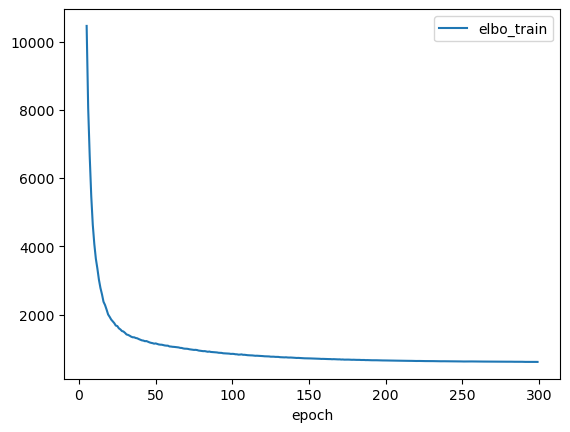

In [30]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and performance deteriorates as max_epochs\<200.

#### Deconvolution with stLVM

As a second step, we train our deconvolution model: spatial transcriptomics Latent Variable Model (stLVM).
We setup the DestVI model using the `counts` layer in `st_adata` that contains the raw counts. We then pass the trained `CondSCVI` model and generate a new model based on `st_adata` and `sc_model` using `DestVI.from_rna_model`.

The decoder network architecture will be generated from `sc_model`. Two neural networks are initiated for cell type proportions and gamma value amortization. Training will take around 5 minutes in a Colab GPU session.

Potential adaptations of `DestVI.from_rna_model` are:

1. increasing `vamp_prior_p` leads to less gradual changes in gamma values
1. more discretized values. Increasing `l1_sparsity` will lead to sparser results for cell type proportions.
1. Although we recommend using similar sequencing technology for both assays, consider changing `beta_weighting_prior` otherwise.

Technical Note: During inference, we adopt a variational mixture of posterior as a prior to enforce gamma values in stLVM match scLVM (see details in original publication). This empirical prior is based on cell type specific subclustering (using k-means to find `vamp_prior_p` clusters) of the posterior distribution in latent space for every cell.

In [31]:
DestVI.setup_anndata(st_adata, layer="counts")

In [32]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 2500  │
│      n_vars      │ 1999  │
└──────────────────┴───────┘

              Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['counts'] │
│    ind_x     │ adata.obs['_indices']  │
└──────────────┴────────────────────────┘

In [33]:
st_model.train(max_epochs=2500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|███████████████████████████████████████████████████████████████████████| 2500/2500 [06:03<00:00,  7.04it/s, loss=5.4e+06, v_num=1]

`Trainer.fit` stopped: `max_epochs=2500` reached.


Epoch 2500/2500: 100%|███████████████████████████████████████████████████████████████████████| 2500/2500 [06:03<00:00,  6.89it/s, loss=5.4e+06, v_num=1]


Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and we advocate against max_epochs\<1000.

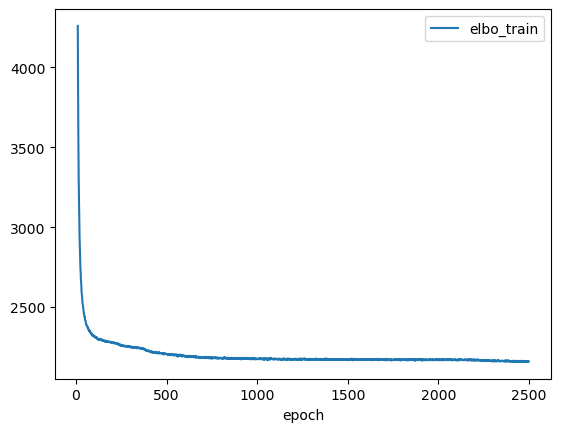

In [34]:
st_model.history["elbo_train"].iloc[10:].plot()
plt.show()

The output of DestVI has two resolution. At the broader resolution, DestVI returns the cell type proportion in every spot. At the more granular resolution, DestVI can impute cell type specific gene expression in every spot.

#### Cell type proportions

We extract the computed cell type proportions and display them in spatial embedding. These values are directly calculated by normalized the spot-level parameters from the stLVM model.

In [35]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [36]:
st_adata.obsm["proportions"].head(5)

,CAFs,Cancer_Epithelial,Myeloid,Normal_Epithelial,T-cells
location_0,0.556306,0.018004,0.003128,0.000132,0.422430
location_1,0.738677,0.030375,0.022321,0.000052,0.208574
location_2,0.616236,0.019391,0.213311,0.000221,0.150840
location_3,0.602486,0.006153,0.358815,0.000053,0.032494
location_4,0.338790,0.004711,0.652119,0.000164,0.004216


In [39]:
st_adata.obsm["proportions"].to_csv(os.path.join(results_path, 'DestVI_proportion_simu_5.csv'), index=True)

### (2). Fine-grained cell-type simulation (`simu_10`)

#### Data loading & propcessing

Load scRNA-seq data:

In [3]:
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'
spatial_path = '../data/simu_10/' 
results_path = '../simulation/results/'

In [4]:
# Load cell & gene labels
barcode_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_barcodes.tsv'), 
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE barcode
)

gene_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_genes.tsv'),
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE gene
)

# Construct adata object for scRNA-seq
barcodes = pd.DataFrame(barcode_df[0].values, index=barcode_df[0].values, columns=['Barcode'])
genes = pd.DataFrame(gene_df[0].values, index=gene_df[0].values, columns=['features'])

cnt = mmread(
    os.path.join(sc_path, 'count_matrix_sparse.mtx')
).toarray()

sc_adata = sc.AnnData(
    X=cnt.T,
    obs=barcodes,
    var=genes
)
print(sc_adata.shape)

/tmp/ipykernel_3622649/2795640389.py:22: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sc_adata = sc.AnnData(


(7986, 29733)


In [5]:
# Load ground-truth proportion & densities
mem_df = pd.read_csv(os.path.join(spatial_path, 'members.st_synth.csv'),index_col=0)
prop_df = pd.read_csv(os.path.join(spatial_path, 'proportions.st_synth.csv'),index_col=0)

In [6]:
# Get subbset-level annotations from available cell types in ground-truth
subset_dict = {
    'Cancer Basal SC':                  'Basal',
    'Cancer LumB SC':                   'LumB',
    'Myoepithelial':                    'Normal epithelial',
    'T_cells_c0_CD4+_CCR7':             'Tcm',
    'T_cells_c1_CD4+_IL7R':             'Tem',
    'T_cells_c3_CD4+_Tfh_CXCL13':       'Tfh',
    'T_cells_c2_CD4+_T-regs_FOXP3':     'Treg',
    'T_cells_c7_CD8+_IFNG':             'Activated CD8',
    'T_cells_c8_CD8+_LAG3':             'Terminal exhaustion',
    'B cells Memory':                   'B cells memory',
    'B cells Naive':                    'B cells naive',
    'Myeloid_c10_Macrophage_1_EGR1':    'Macrophage M1',
    'Myeloid_c9_Macrophage_2_CXCL10':   'Macrophage M2',
    'Plasmablasts':                     'Plasmablasts',
    'Myeloid_c7_Monocyte_3_FCGR3A':     'Monocytes',
    'Myeloid_c12_Monocyte_1_IL1B':      'Monocytes',
    'Myeloid_c8_Monocyte_2_S100A9':     'Monocytes',
    'Myeloid_c11_cDC2_CD1C':            'cDC',
    'Myeloid_c3_cDC1_CLEC9A':           'cDC',
    'Myeloid_c4_DCs_pDC_IRF7':          'pDC',
    'CAFs MSC iCAF-like s1':            'CAFs MSC iCAF-like',
    'CAFs MSC iCAF-like s2':            'CAFs MSC iCAF-like',
    'CAFs myCAF like s4':               'CAFs myCAF-like',
    'CAFs myCAF like s5':               'CAFs myCAF-like',
    'PVL Immature s1':                  'PVL immature',
    'PVL_Immature s2':                  'PVL immature',
    'PVL Differentiated s3':            'PVL differentiated',
    'Endothelial ACKR1':                'Endothelial',
    'Endothelial CXCL12':               'Endothelial',
    'Endothelial Lymphatic LYVE1':      'Endothelial',
    'Endothelial RGS5':                 'Endothelial'
}

In [7]:
# Rename annotations & only keep scRNA-seq index with cell types existing in the synthetic ST data
meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)
annots = meta_df['celltype_subset'].apply(lambda x: subset_dict[x] if x in subset_dict.keys() else np.nan)

cells_to_keep = annots.isin(prop_df.columns)
sc_adata = sc_adata[cells_to_keep, :]
annots = annots[cells_to_keep]
sc_adata.obs['subset_cell_types'] = annots[cells_to_keep].tolist()

sc_adata

/tmp/ipykernel_3622649/1685941705.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata.obs['subset_cell_types'] = annots[cells_to_keep].tolist()


AnnData object with n_obs × n_vars = 3901 × 29733
    obs: 'Barcode', 'subset_cell_types'
    var: 'features'

Load simulated spatial data:

In [8]:
st_adata = sc.AnnData(pd.read_csv(os.path.join(spatial_path, 'counts.st_synth.csv'), index_col=0))

# Add spatial locations
xx, yy = np.meshgrid(np.arange(50), np.arange(50), indexing='ij')
xx, yy = xx.flatten(), yy.flatten()
st_adata.obsm["location"] = np.column_stack((yy, xx))

st_adata

/tmp/ipykernel_3622649/2168565385.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  st_adata = sc.AnnData(pd.read_csv(os.path.join(spatial_path, 'counts.st_synth.csv'), index_col=0))


AnnData object with n_obs × n_vars = 2500 × 29733
    obsm: 'location'

In [10]:
# visualization of sc data
sc_vis = sc_adata.copy()
sc.pp.normalize_total(sc_vis, target_sum=1e4)
sc.pp.log1p(sc_vis)

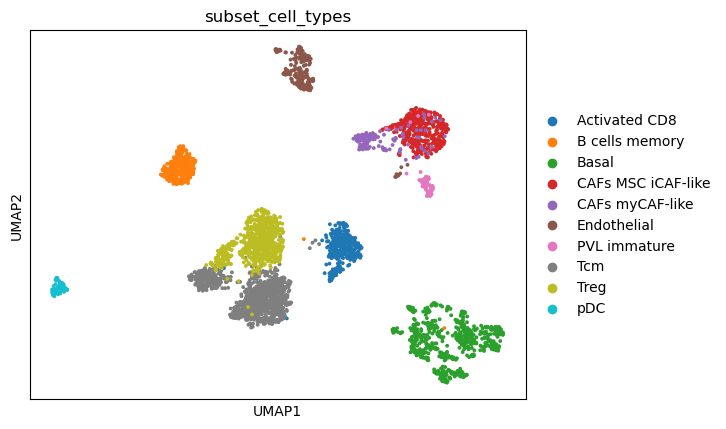

In [12]:
sc.pp.neighbors(sc_vis, n_neighbors=10, n_pcs=40)
sc.tl.umap(sc_vis)
sc.pl.umap(sc_vis, color="subset_cell_types")

Preprocessing & selecting intersection genes between scRNA-seq reference and spatial data:

In [13]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

In [14]:
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.obsm["spatial"] = st_adata.obsm["location"]

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [15]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

#### Fit the scLVM

In [16]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="subset_cell_types")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [17]:
sc_model = CondSCVI(sc_adata, weight_obs=False)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'subset_cell_types', 'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 3901  │
│     n_labels     │  10   │
│      n_vars      │ 2000  │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['subset_cell_types'] │   Activated CD8    │          0          │
│                                │   B cells memory   │          1          │
│                                │       Basal        │          2          │
│                                │ CAFs MSC iCAF-like │          3          │
│                                │  CAFs myCAF-like   │          4          │
│                                │    Endothelial     │          5          │
│                                │    PVL immature    │          6          │
│                                │        Tcm         │          7          │
│                                │        Treg        │          8          │
│                                │        pDC         │          9          │
└────────────────────────────────┴────────────────────┴─────────────────────┘

In [18]:
sc_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.54it/s, loss=715, v_num=1]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, loss=715, v_num=1]


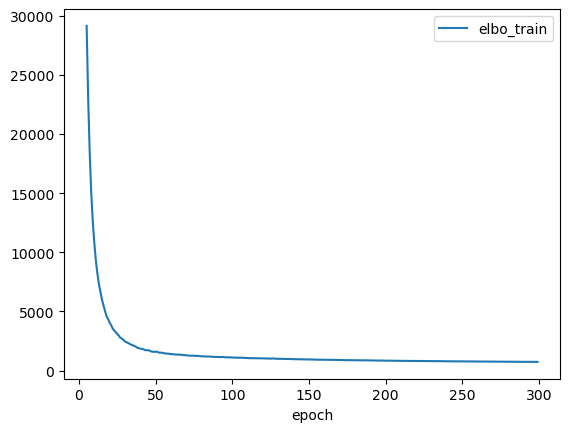

In [19]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

#### Deconvolution with stLVM

In [20]:
DestVI.setup_anndata(st_adata, layer="counts")

In [26]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

Epoch 113/2500:   4%|███▏                                                                    | 112/2500 [00:48<17:17,  2.30it/s, loss=2.14e+06, v_num=1]


Anndata setup with scvi-tools version 0.20.3.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 2500  │
│      n_vars      │ 2000  │
└──────────────────┴───────┘

              Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['counts'] │
│    ind_x     │ adata.obs['_indices']  │
└──────────────┴────────────────────────┘

In [27]:
st_model.train(max_epochs=2500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|██████████████████████████████████████████████████████████████████████| 2500/2500 [06:10<00:00,  6.69it/s, loss=1.99e+06, v_num=1]

`Trainer.fit` stopped: `max_epochs=2500` reached.


Epoch 2500/2500: 100%|██████████████████████████████████████████████████████████████████████| 2500/2500 [06:10<00:00,  6.74it/s, loss=1.99e+06, v_num=1]


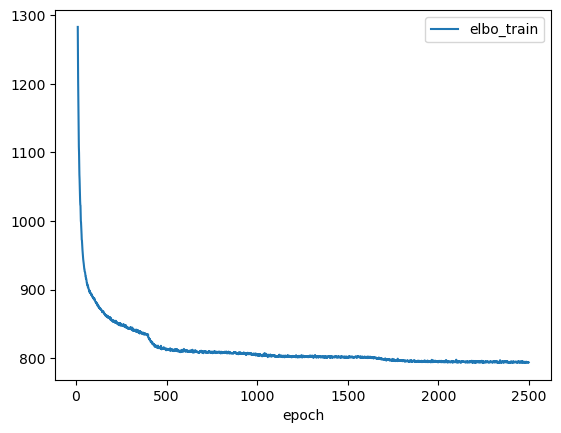

In [28]:
st_model.history["elbo_train"].iloc[10:].plot()
plt.show()

#### Cell type proportions

In [29]:
st_adata.obsm["proportions"] = st_model.get_proportions()
st_adata.obsm["proportions"].head()

,Activated CD8,B cells memory,Basal,CAFs MSC iCAF-like,CAFs myCAF-like,Endothelial,PVL immature,Tcm,Treg,pDC
exper0_location_0,0.000755,0.092649,0.000041,0.685812,0.180534,0.000037,0.000212,3.994285e-02,0.000017,3.600814e-07
exper0_location_1,0.000014,0.049168,0.000121,0.678601,0.131025,0.000032,0.000350,1.249823e-03,0.139421,1.807991e-05
exper0_location_2,0.000015,0.024603,0.036893,0.697118,0.234962,0.006393,0.000003,2.272890e-07,0.000013,5.419283e-10
exper0_location_3,0.000076,0.002334,0.171381,0.616252,0.069133,0.000007,0.000009,9.558923e-02,0.045219,2.377911e-07
exper0_location_4,0.002369,0.001165,0.260534,0.516827,0.154351,0.000004,0.000020,4.701957e-04,0.064198,6.152027e-05


In [30]:
st_adata. obsm["proportions"].to_csv(os.path.join(results_path, 'DestVI_proportion_simu_10.csv'), index=True)

---